## 0. Клонирование репозитория BAMT

In [4]:
!git clone https://github.com/ITMO-NSS-team/BAMT

Cloning into 'BAMT'...


## 1. Обучение структур БС с различными гиперпараметрами

In [58]:
%%time
%matplotlib inline
import bamt.Networks as Nets
import bamt.Preprocessors as pp

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn import preprocessing
from pgmpy.estimators import K2Score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib.pyplot as plt

CPU times: total: 0 ns
Wall time: 2.05 ms


In [14]:
data = pd.read_csv('sangiovese.csv', index_col=0)
data.head()

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
1,T6b,0.202349,0.295120,0.007353,-0.044060,0.123074,-0.011439,0.012205,0.085229,0.203979,-0.104303,-0.127506,-0.051799,-0.275240,-0.193690
2,T7b,0.266060,0.425589,0.119441,0.410288,-0.003285,0.026199,0.140954,0.113828,0.046233,-0.150271,0.075906,0.004393,0.280481,0.379005
3,T8b,0.415644,0.078505,0.439378,0.363778,0.100210,0.090508,0.040111,-0.019662,-0.138107,-0.027917,0.003320,0.041966,-0.016803,-0.259305
4,T4a,-0.120736,0.073215,-0.310475,0.122281,-0.115675,-0.043585,0.042341,0.154439,-0.088854,0.049449,0.095224,0.035857,-0.057244,-0.141223
5,T5b,0.108829,0.355558,-0.483608,-0.525597,-0.173176,-0.139314,-0.216183,-0.121072,0.052817,-0.315021,0.062484,-0.008910,-0.023187,0.172194


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Treatment  1000 non-null   object 
 1   SproutN    1000 non-null   float64
 2   BunchN     1000 non-null   float64
 3   GrapeW     1000 non-null   float64
 4   WoodW      1000 non-null   float64
 5   SPAD06     1000 non-null   float64
 6   NDVI06     1000 non-null   float64
 7   SPAD08     1000 non-null   float64
 8   NDVI08     1000 non-null   float64
 9   Acid       1000 non-null   float64
 10  Potass     1000 non-null   float64
 11  Brix       1000 non-null   float64
 12  pH         1000 non-null   float64
 13  Anthoc     1000 non-null   float64
 14  Polyph     1000 non-null   float64
dtypes: float64(14), object(1)
memory usage: 125.0+ KB


In [16]:
# инициализация кодировщика и дискретизатора данных
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# передача параметров для препроцессинга данных 
p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(data)

In [17]:
discretized_data

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,11,4,3,2,2,4,2,2,3,4,1,0,0,1,1
1,13,4,4,2,4,2,2,4,3,2,0,4,2,3,4
2,15,4,2,3,3,4,4,3,2,0,2,2,4,2,0
3,6,1,2,1,3,0,1,3,4,1,3,4,4,2,1
4,9,3,4,1,0,0,0,0,0,3,0,3,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,1,1,3,4,3,3,3,2,3,3,2,2,3,2
996,1,0,0,0,1,2,2,0,1,4,0,3,0,4,4
997,15,4,0,3,3,4,4,4,4,0,3,1,4,3,0
998,0,1,1,1,2,2,3,1,1,3,3,1,2,1,1


In [102]:
def qqplot(column, validation_sample, sample, title):
    """Построение графика квантиль-квантиль"""
    sample_values = sample[column].values
    validation_sample_values = validation_sample[column].values

    df_pct = pd.DataFrame()
    df_pct['q_sample'] = np.percentile(sample_values, range(100))
    df_pct['q_validation'] = np.percentile(validation_sample_values, range(100))
    
    with plt.style.context('bmh'):
        fig, ax = plt.subplots(figsize = (7,7))
        ax.scatter(x='q_validation', y='q_sample', data=df_pct, label='Actual fit');
        sns.lineplot(x='q_validation', y='q_validation', data=df_pct, color='r', label='Line of perfect fit');
        ax.set_xlabel('Quantile for validation sample')
        ax.set_ylabel('Quantile for fit sample')
        ax.legend()
        ax.set_title(f"QQ plot. {title}.");

### 1.1. K2 metric

In [55]:
# инициализация сети
bn_1 = Nets.HybridBN(has_logit=False, use_mixture=False)
info = p.info

In [56]:
info

{'types': {'Treatment': 'disc',
  'SproutN': 'cont',
  'BunchN': 'cont',
  'GrapeW': 'cont',
  'WoodW': 'cont',
  'SPAD06': 'cont',
  'NDVI06': 'cont',
  'SPAD08': 'cont',
  'NDVI08': 'cont',
  'Acid': 'cont',
  'Potass': 'cont',
  'Brix': 'cont',
  'pH': 'cont',
  'Anthoc': 'cont',
  'Polyph': 'cont'},
 'signs': {'SproutN': 'neg',
  'BunchN': 'neg',
  'GrapeW': 'neg',
  'WoodW': 'neg',
  'SPAD06': 'neg',
  'NDVI06': 'neg',
  'SPAD08': 'neg',
  'NDVI08': 'neg',
  'Acid': 'neg',
  'Potass': 'neg',
  'Brix': 'neg',
  'pH': 'neg',
  'Anthoc': 'neg',
  'Polyph': 'neg'}}

In [59]:
# добавление ребер графа
bn_1.add_nodes(info)

bn_1.add_edges(discretized_data, scoring_function=('K2',K2Score)) 

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [60]:
bn_1.get_info()

,name,node_type,data_type,parents,parents_types
0,Treatment,Discrete,disc,[],[]
1,SproutN,ConditionalGaussian,cont,[Treatment],[disc]
2,SPAD08,Gaussian,cont,[SproutN],[cont]
3,WoodW,Gaussian,cont,[SPAD08],[cont]
4,NDVI06,Gaussian,cont,[SPAD08],[cont]
5,GrapeW,Gaussian,cont,[WoodW],[cont]
6,NDVI08,Gaussian,cont,[WoodW],[cont]
7,SPAD06,Gaussian,cont,"[WoodW, SPAD08]","[cont, cont]"
8,BunchN,Gaussian,cont,[GrapeW],[cont]
9,Polyph,Gaussian,cont,[GrapeW],[cont]


In [61]:
# обучение модели
bn_1.fit_parameters(data)

#### 1.1.1 Sampling

In [110]:
# выберем один узел и инициализируем его одним значением из датасета и произведем семплирование
sample_1 = bn.sample(5000, evidence={'Treatment': 'T6b'}, parall_count=5)

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 16604.07it/s]


In [111]:
#Исходное распределение, построенное основе подвыборки, в которой узел принимает значение, заданное при семплировании
validation_sample = data.loc[data['Treatment'] == 'T6b']
validation_sample.head()

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
1,T6b,0.202349,0.295120,0.007353,-0.044060,0.123074,-0.011439,0.012205,0.085229,0.203979,-0.104303,-0.127506,-0.051799,-0.275240,-0.193690
32,T6b,0.107619,0.008006,0.107225,0.682773,0.106099,-0.036676,0.075605,0.077072,0.079420,-0.127613,0.041137,-0.015397,-0.183474,0.221827
67,T6b,-0.164754,-1.283483,-0.284646,-0.623483,-0.124363,0.031829,-0.124892,-0.165586,-0.124490,0.001866,0.072069,-0.005097,-0.277774,-0.187138
83,T6b,-0.059196,0.218286,-0.296605,0.045130,-0.081833,-0.028702,0.091469,0.125084,0.046937,0.022817,0.167912,0.027440,-0.382665,-0.259329
86,T6b,0.063641,0.631026,1.144906,0.324235,0.045215,0.029493,0.043016,0.095512,-0.055753,0.090173,-0.056981,0.041352,0.082827,0.287821


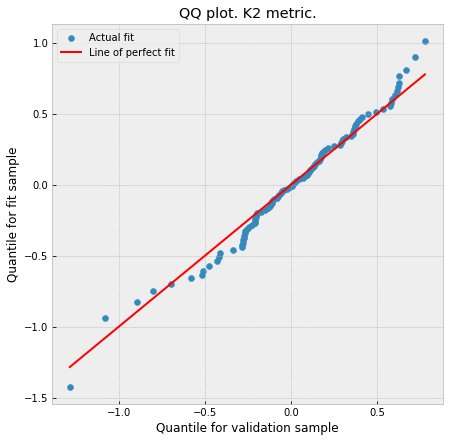

In [112]:
# Выберем другой узел и сравним распределение в этом узле с исходным распределением
qqplot('BunchN', validation_sample, sample_1, 'K2 metric')

### 1.2. K2 + GMM + logit nodes

In [66]:
# инициализация сети
bn_2 = Nets.HybridBN(has_logit=True, use_mixture=True)
info = p.info

In [67]:
# добавление ребер графа
bn_2.add_nodes(info)

bn_2.add_edges(discretized_data, scoring_function=('K2',K2Score)) 

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [68]:
bn_2.get_info()

,name,node_type,data_type,parents,parents_types
0,SPAD08,MixtureGaussian,cont,[],[]
1,WoodW,MixtureGaussian,cont,[SPAD08],[cont]
2,NDVI06,MixtureGaussian,cont,[SPAD08],[cont]
3,GrapeW,MixtureGaussian,cont,[WoodW],[cont]
4,NDVI08,MixtureGaussian,cont,[WoodW],[cont]
5,SPAD06,MixtureGaussian,cont,"[WoodW, SPAD08]","[cont, cont]"
6,BunchN,MixtureGaussian,cont,[GrapeW],[cont]
7,Polyph,MixtureGaussian,cont,[GrapeW],[cont]
8,Brix,MixtureGaussian,cont,[GrapeW],[cont]
9,SproutN,MixtureGaussian,cont,"[BunchN, WoodW]","[cont, cont]"


In [69]:
# обучение модели
bn_2.fit_parameters(data)

#### 1.2.1. Sampling

In [108]:
# выберем один узел и инициализируем его одним значением из датасета и произведем семплирование
sample_2 = bn.sample(5000, evidence={'Treatment': 'T6b'}, parall_count=5)

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 15578.25it/s]


In [71]:
#Исходное распределение, построенное основе подвыборки, в которой узел принимает значение, заданное при семплировании
validation_sample = data.loc[data['Treatment'] == 'T6b']
validation_sample.head()

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
1,T6b,0.202349,0.295120,0.007353,-0.044060,0.123074,-0.011439,0.012205,0.085229,0.203979,-0.104303,-0.127506,-0.051799,-0.275240,-0.193690
32,T6b,0.107619,0.008006,0.107225,0.682773,0.106099,-0.036676,0.075605,0.077072,0.079420,-0.127613,0.041137,-0.015397,-0.183474,0.221827
67,T6b,-0.164754,-1.283483,-0.284646,-0.623483,-0.124363,0.031829,-0.124892,-0.165586,-0.124490,0.001866,0.072069,-0.005097,-0.277774,-0.187138
83,T6b,-0.059196,0.218286,-0.296605,0.045130,-0.081833,-0.028702,0.091469,0.125084,0.046937,0.022817,0.167912,0.027440,-0.382665,-0.259329
86,T6b,0.063641,0.631026,1.144906,0.324235,0.045215,0.029493,0.043016,0.095512,-0.055753,0.090173,-0.056981,0.041352,0.082827,0.287821


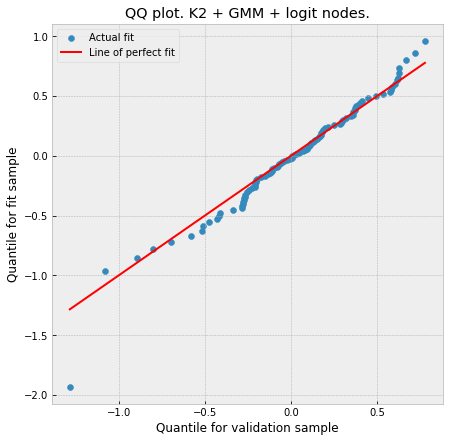

In [109]:
qqplot('BunchN', validation_sample, sample_2, 'K2 + GMM + logit nodes')

### 1.3. MI + GMM + logit nodes

In [77]:
# инициализация сети
bn_3 = Nets.HybridBN(has_logit=True, use_mixture=True)
info = p.info

In [78]:
# добавление ребер графа
bn_3.add_nodes(info)

bn_3.add_edges(discretized_data, scoring_function=('MI',)) 

In [79]:
bn_3.get_info()

,name,node_type,data_type,parents,parents_types
0,SproutN,MixtureGaussian,cont,[],[]
1,Potass,MixtureGaussian,cont,[SproutN],[cont]
2,NDVI06,MixtureGaussian,cont,[Potass],[cont]
3,NDVI08,MixtureGaussian,cont,[Potass],[cont]
4,Brix,MixtureGaussian,cont,[Potass],[cont]
5,Polyph,MixtureGaussian,cont,[Potass],[cont]
6,BunchN,MixtureGaussian,cont,[NDVI06],[cont]
7,SPAD08,MixtureGaussian,cont,[BunchN],[cont]
8,Treatment,Logit (LogisticRegression),disc,[SPAD08],[cont]
9,GrapeW,ConditionalMixtureGaussian,cont,"[Potass, Treatment]","[cont, disc]"


In [80]:
# обучение модели
bn_3.fit_parameters(data)

#### 1.3.1. Sampling

In [105]:
# выберем один узел и инициализируем его одним значением из датасета и произведем семплирование
sample_3 = bn.sample(5000, evidence={'Treatment': 'T6b'}, parall_count=5)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 754.65it/s]


In [106]:
#Исходное распределение, построенное основе подвыборки, в которой узел принимает значение, заданное при семплировании
validation_sample = data.loc[data['Treatment'] == 'T6b']
validation_sample.head()

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
1,T6b,0.202349,0.295120,0.007353,-0.044060,0.123074,-0.011439,0.012205,0.085229,0.203979,-0.104303,-0.127506,-0.051799,-0.275240,-0.193690
32,T6b,0.107619,0.008006,0.107225,0.682773,0.106099,-0.036676,0.075605,0.077072,0.079420,-0.127613,0.041137,-0.015397,-0.183474,0.221827
67,T6b,-0.164754,-1.283483,-0.284646,-0.623483,-0.124363,0.031829,-0.124892,-0.165586,-0.124490,0.001866,0.072069,-0.005097,-0.277774,-0.187138
83,T6b,-0.059196,0.218286,-0.296605,0.045130,-0.081833,-0.028702,0.091469,0.125084,0.046937,0.022817,0.167912,0.027440,-0.382665,-0.259329
86,T6b,0.063641,0.631026,1.144906,0.324235,0.045215,0.029493,0.043016,0.095512,-0.055753,0.090173,-0.056981,0.041352,0.082827,0.287821


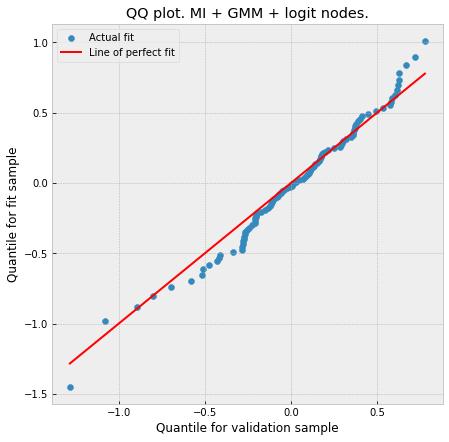

In [107]:
qqplot('BunchN', validation_sample, sample_3, 'MI + GMM + logit nodes')

## 2. Выводы о полученных структурах и их сравнение

Еща раз построим полученные графики для визуальной наглядности:

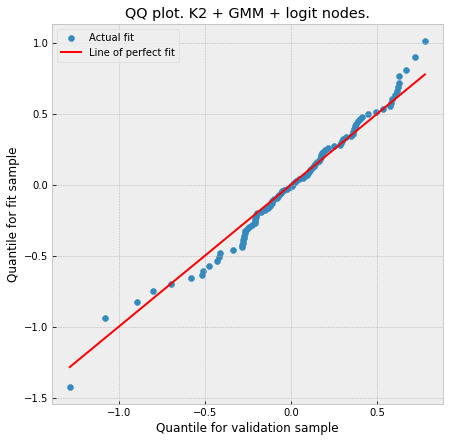

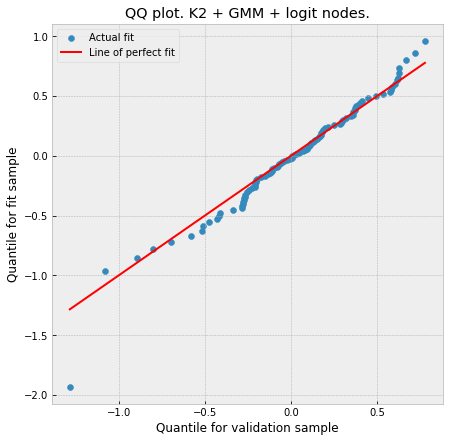

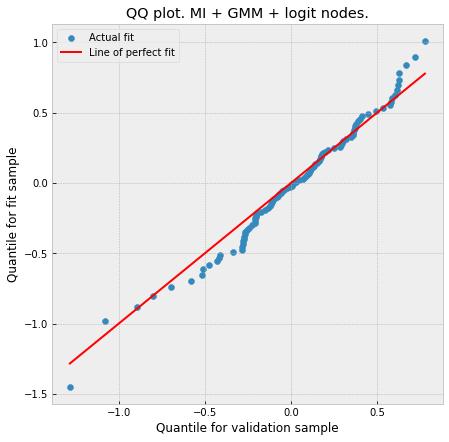

In [115]:
qqplot('BunchN', validation_sample, sample_1, 'K2 + GMM + logit nodes')
qqplot('BunchN', validation_sample, sample_2, 'K2 + GMM + logit nodes')
qqplot('BunchN', validation_sample, sample_3, 'MI + GMM + logit nodes')

Исходя из построенных графиков квантиль-квантиль, видно, что семплированные распределения имеют **схожие медианы** к исходным (пересечение линий в центре). Смещения точек сверху и снизу графика говорит о форме распределения, на всех представленных графиках имеются **тяжелые хвосты**. 

Таким образом, из виузального сравнения, наиболее **меньшее отклонение** от исходного распределения представляется для второй модели байесовской сети **"K2 + GMM + logit nodes"**.